In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv('/kaggle/input/apple-daily-dataset/AAPL_day_new.csv')
data.tail()

,Date,Open,High,Low,Close,Volume,SMA,EMA,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower
3792,2025-01-30 00:00:00-05:00,238.669998,240.789993,237.210007,237.589996,55658300,240.007999,236.966431,51.292713,-2.707687,-3.449165,251.427544,219.188455
3793,2025-01-31 00:00:00-05:00,247.190002,247.190002,233.440002,236.000000,101075100,240.227999,236.928531,49.385827,-2.323502,-3.224032,249.153455,220.020544
3794,2025-02-03 00:00:00-05:00,229.990005,231.830002,225.699997,228.009995,73063300,240.227799,236.578785,41.114110,-2.633402,-3.105906,247.978204,219.611794
3795,2025-02-04 00:00:00-05:00,227.250000,233.130005,226.649994,232.800003,45067300,240.318199,236.430597,46.860376,-2.464083,-2.977541,246.755822,219.778177
3796,2025-02-05 00:00:00-05:00,228.529999,232.669998,228.270004,232.470001,39620300,240.387599,236.275280,46.523545,-2.329669,-2.847967,245.008712,220.272286


In [3]:
def preprocessing(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)
    
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    scaler = MinMaxScaler()

    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

    return data

In [4]:
apple_stock = preprocessing(data)
apple_stock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3797 entries, 2010-01-04 00:00:00-05:00 to 2025-02-05 00:00:00-05:00
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         3797 non-null   float64
 1   High         3797 non-null   float64
 2   Low          3797 non-null   float64
 3   Close        3797 non-null   float64
 4   Volume       3797 non-null   float64
 5   SMA          3797 non-null   float64
 6   EMA          3797 non-null   float64
 7   RSI          3797 non-null   float64
 8   MACD         3797 non-null   float64
 9   MACD_Signal  3797 non-null   float64
 10  BB_Upper     3797 non-null   float64
 11  BB_Lower     3797 non-null   float64
dtypes: float64(12)
memory usage: 385.6+ KB


<ipython-input-3-80cb02926627>:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])
<ipython-input-3-80cb02926627>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-3-80cb02926627>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [5]:
columns = ['Open', 'Low', 'High', 'Volume', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_Signal', 'BB_Upper', 'BB_Lower' ]

In [77]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, num_layers=2, dropout=0.2):
        super(LSTM, self).__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.num_layers = num_layers
        
        self.batch_norm1 = nn.BatchNorm1d(hidden_size1 * 2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2 * 2)
        
        self.lstm1 = nn.LSTM(input_size, hidden_size1, num_layers=num_layers,
                           dropout=dropout if num_layers > 1 else 0,
                           batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size1 * 2, 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        device = x.device
        
        h1 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size1).to(device)
        c1 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size1).to(device)
        h2 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size2).to(device)
        c2 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size2).to(device)
        
        out, (h1, c1) = self.lstm1(x, (h1, c1))
        out = out.transpose(1, 2)
        out = self.batch_norm1(out)
        out = out.transpose(1, 2)
        out = self.dropout(out)
        
        out = self.fc(out[:, -1, :])
        return out

In [7]:
def create_sequences(data, targets, sequence_length):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]  
        label = targets[i + sequence_length] 
        sequences.append(seq)
        labels.append(label)

    sequences = np.array(sequences)
    labels = np.array(labels)

    # sequences = np.transpose(sequences, (0, 2, 1))  
    return sequences, labels

In [8]:
def prepare_dataloaders(data, feature_columns, target_column, sequence_length, batch_size, test_size=0.1):
    X = data[feature_columns].values
    y = data[target_column].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=test_size, shuffle=False)
    
    x_train, y_train = create_sequences(X_train, Y_train, sequence_length)
    x_val, y_val = create_sequences(X_val, Y_val, sequence_length)
    x_test, y_test = create_sequences(X_test, Y_test, sequence_length)
    
    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader, test_dataloader, y_test

In [9]:
def evaluate_model(model, dataloader, criterion, device='cuda'):
    model.eval()
    total_loss = 0.0
    all_targets = []
    all_outputs = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            all_targets.append(targets.cpu().detach().numpy())
            all_outputs.append(outputs.cpu().detach().numpy())
            
    avg_loss = total_loss / len(dataloader.dataset)
    targets = np.concatenate(all_targets)
    outputs = np.concatenate(all_outputs)
    
    mse = np.mean((outputs - targets) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(outputs - targets))
    
    return avg_loss, rmse, mae

In [10]:
def plot_metrics(predictions, targets, name):
    
    predictions_natural = predictions.flatten()
    targets_natural = targets.flatten() 

    plt.figure(figsize=(10, 6))
    plt.plot(targets_natural, label="Real Values", color='blue')
    plt.plot(predictions_natural, label="Predicted Values", color='red', linestyle='dashed')
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Real vs Predicted Values')
    plt.legend()
    plt.savefig(name, dpi=99) 
    plt.show()

In [11]:
def evaluate_on_test(model, test_dataloader, criterion, device):
    model.eval()  
    test_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():  
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            # print("targets", targets)
            # print("Prediction", outputs)
            loss = criterion(outputs, targets)  
            test_loss += loss.item() * inputs.size(0) 
            
            all_predictions.append(outputs.cpu().numpy())  
            all_targets.append(targets.cpu().numpy())
    
    test_loss /= len(test_dataloader.dataset)
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    mae = mean_absolute_error(all_targets, all_predictions)
    
    return all_predictions

In [12]:
def train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets_test, model, criterion, optimizer, num_epochs, device, name_model, png):
    model.to(device)
    best_val_loss = float('inf')
    
    train_rmse_list, train_mae_list = [], []
    val_rmse_list, val_mae_list = [], []
    train_loss_list, val_loss_list = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        all_train_targets = []
        all_train_outputs = []
        
        batch_inputs = []
        batch_targets = []
        
        for inputs, targets in train_dataloader:
            batch_inputs.append(inputs.to(device))
            batch_targets.append(targets.float().to(device))
            
        inputs = torch.cat(batch_inputs)
        targets = torch.cat(batch_targets)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        outputs = outputs.view_as(targets)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss = loss.item() * inputs.size(0)
        all_train_targets.append(targets.cpu().detach().numpy())
        all_train_outputs.append(outputs.cpu().detach().numpy())
        
        train_targets = np.concatenate(all_train_targets)
        train_outputs = np.concatenate(all_train_outputs)
        
        train_mse = np.mean((train_outputs - train_targets) ** 2)
        train_rmse = np.sqrt(train_mse)
        train_mae = np.mean(np.abs(train_outputs - train_targets))
        
        train_rmse_list.append(train_rmse)
        train_mae_list.append(train_mae)
        train_loss_list.append(train_loss / len(train_dataloader.dataset))
        
        val_loss, val_rmse, val_mae = evaluate_model(model, val_dataloader, criterion, device)
        val_rmse_list.append(val_rmse)
        val_mae_list.append(val_mae)
        val_loss_list.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), name_model)

        if (epoch % 100) == 0:
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}')
            print(f'Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')
    
    torch.save(model.state_dict(), name_model)
    test_loss, test_rmse, test_mae = evaluate_model(model, test_dataloader, criterion, device)
    predictions = evaluate_on_test(model, test_dataloader, criterion, device)
    print('\nFinal Results:')
    print(f'Test RMSE: {test_rmse:.4f}')
    print(f'Test MAE: {test_mae:.4f}')

    plot_metrics(predictions, targets_test, png)
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Test timestep 5

Epoch 1/200:
Train RMSE: 0.4647, Train MAE: 0.3728
Val RMSE: 0.5613, Val MAE: 0.5575
Epoch 101/200:
Train RMSE: 0.4472, Train MAE: 0.3582
Val RMSE: 0.0796, Val MAE: 0.0627

Final Results:
Test RMSE: 0.0923
Test MAE: 0.0821


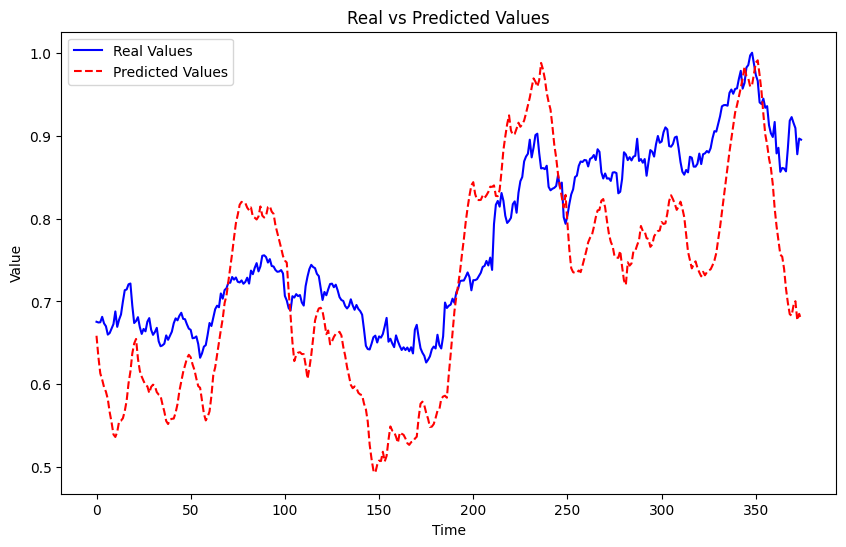

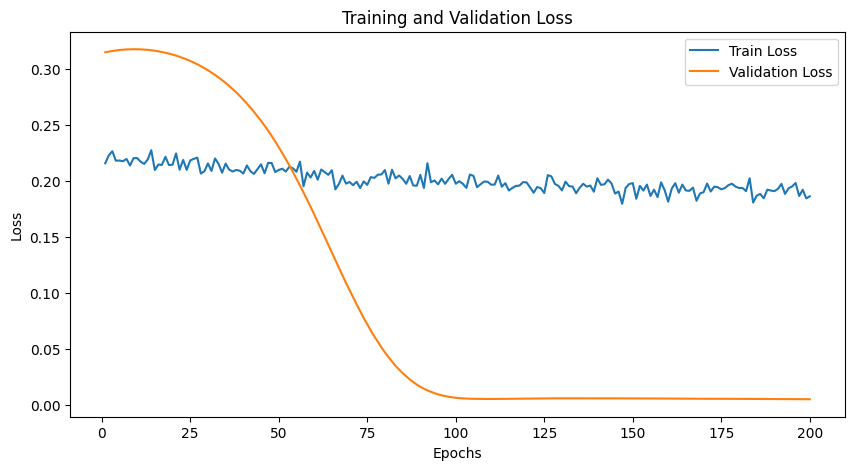

In [78]:
torch.manual_seed(0)
num_epochs = 200
model = LSTM(input_size=11)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 5, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device,  'lstm_model_step_5.pth', 'test_step_5.png')

# Test timestep 10

Epoch 1/200:
Train RMSE: 0.5141, Train MAE: 0.4119
Val RMSE: 0.5584, Val MAE: 0.5546
Epoch 101/200:
Train RMSE: 0.4787, Train MAE: 0.3830
Val RMSE: 0.0921, Val MAE: 0.0716

Final Results:
Test RMSE: 0.0844
Test MAE: 0.0748


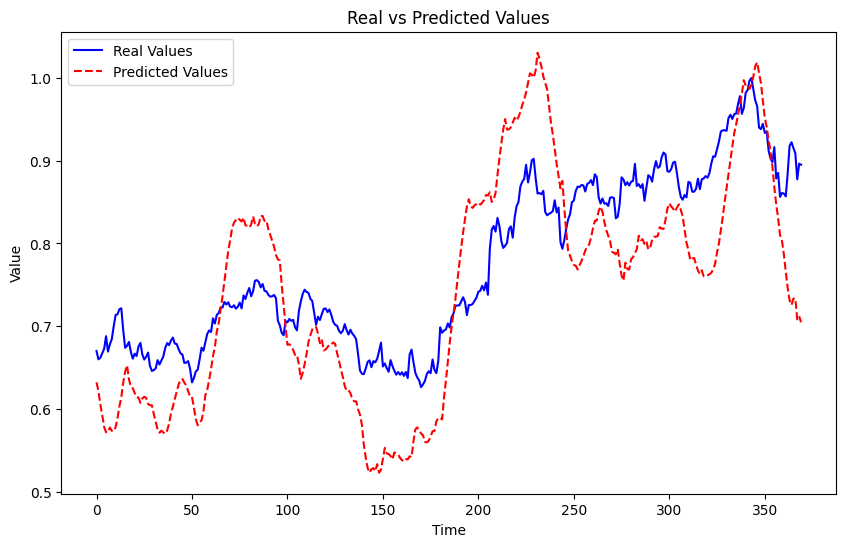

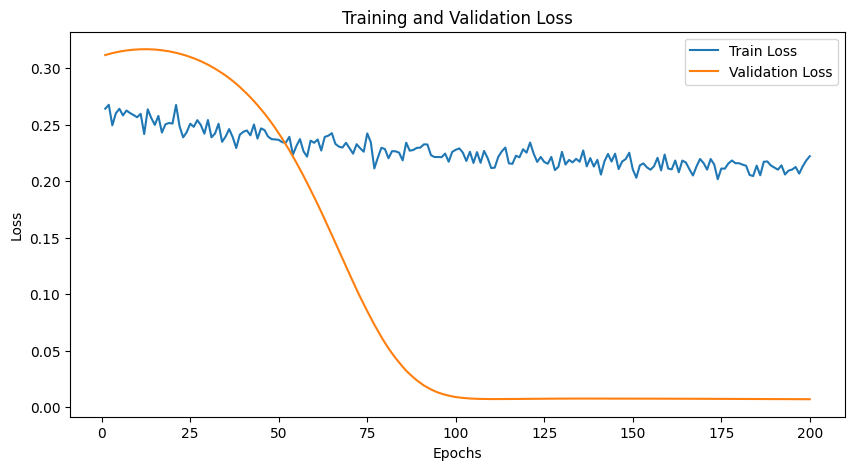

In [73]:
torch.manual_seed(0)
num_epochs = 200
model = LSTM(input_size=11)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 10, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device,  'lstm_model_step_10.pth', 'test_step_10.png')

# Test timestep 20

Epoch 1/200:
Train RMSE: 0.5986, Train MAE: 0.4830
Val RMSE: 0.5572, Val MAE: 0.5534
Epoch 101/200:
Train RMSE: 0.5237, Train MAE: 0.4173
Val RMSE: 0.0972, Val MAE: 0.0762

Final Results:
Test RMSE: 0.0801
Test MAE: 0.0615


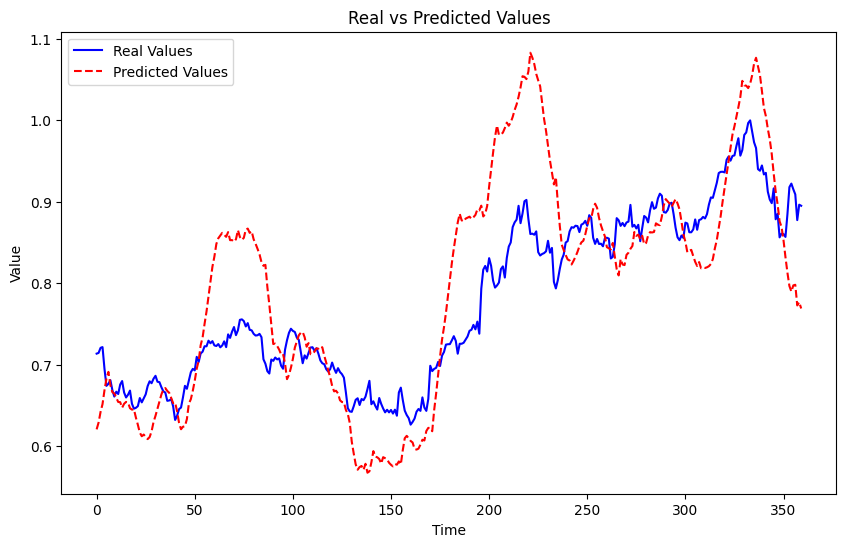

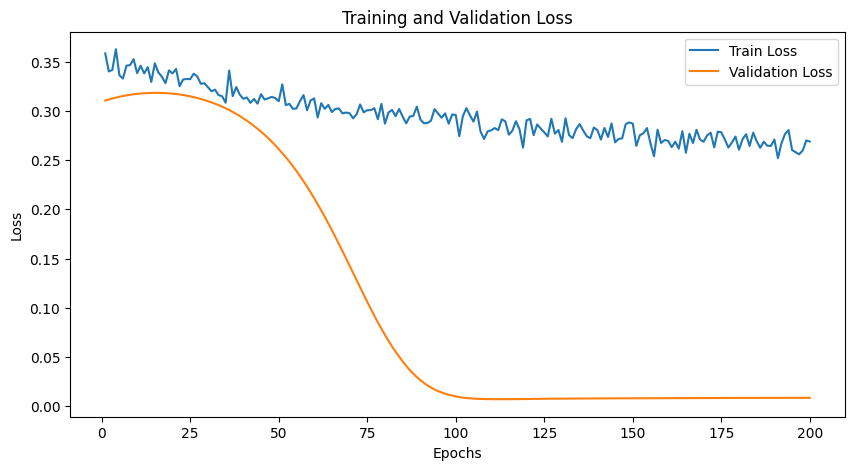

In [72]:
torch.manual_seed(0)
num_epochs = 200
model = LSTM(input_size=11)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device,  'lstm_model_step_20.pth', 'test_step_20.png')